In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
df = pd.read_csv('D:\\BCU Final\\ML\\Dataset\\Wesad Acc\\datasrc\\features.csv')

In [4]:
df['Index'] = df['Subject ID'].astype(str) + df['Gender'].astype(int).astype(str)
total_data = df.sort_values(['Subject ID', 'Gender'])
total_data = total_data.reset_index()
total_data.drop('Index', axis=1, inplace=True)
total_data

,index,chest_acc_x,chest_acc_y,chest_acc_z,chest_ecg,chest_res,chest_temp,label,Subject ID,Gender
0,1443400,0.7200,-0.1382,3.1934,-0.756638,2.204895,31.499023,0.0,3,0
1,1443401,0.5688,-0.2286,3.1822,-0.708206,2.180481,31.501953,0.0,3,0
2,1443402,0.3998,-0.3132,2.9450,-0.673965,2.166748,31.521149,0.0,3,0
3,1443403,0.2454,-0.3838,2.4716,-0.535721,2.191162,31.510834,0.0,3,0
4,1443404,0.0938,-0.4466,1.8758,-0.321808,2.183533,31.516724,0.0,3,0
...,...,...,...,...,...,...,...,...,...,...
16502494,14848393,0.8858,0.0022,-0.2758,0.077454,-7.658386,35.069885,4.0,11,1
16502495,14848394,0.8854,0.0036,-0.2738,0.080063,-7.655334,35.060608,4.0,11,1
16502496,14848395,0.8842,0.0030,-0.2698,0.081436,-7.658386,35.065277,4.0,11,1
16502497,14848396,0.8850,0.0054,-0.2718,0.082626,-7.667542,35.051361,4.0,11,1


In [5]:
total_data.drop('chest_ecg', axis=1, inplace=True)

In [6]:
total_data.drop('chest_res', axis=1, inplace=True)

In [7]:
total_data.drop('Subject ID', axis=1, inplace=True)

In [8]:
total_data.drop('index', axis=1, inplace=True)

In [9]:
X = total_data.drop('label', axis=1)
y = total_data['label']

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)


In [11]:
from sklearn.preprocessing import MinMaxScaler

In [12]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input (if needed)
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [16]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Create a StandardScaler instance
scaler = StandardScaler()

# Scale the data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM input (if needed)
X_train_lstm = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_lstm = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from kerastuner.tuners import RandomSearch

C:\Users\pojit\AppData\Local\Temp\ipykernel_5468\3029673410.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [18]:
X_train_scaled.shape

(12376874, 5)

In [19]:
X_test_scaled.shape

(4125625, 5)

In [20]:
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.layers import Dropout

In [17]:
from tensorflow.keras.layers import Dropout

def build_model(hp):
    model = Sequential()

    # Add the first Dense layer with hyperparameters for units, dropout rate, and kernel
    model.add(Dense(units=hp.Int('units', min_value=8, max_value=512, step=8),
                    activation='relu', input_shape=(X_train_scaled.shape[1],),
                    kernel_initializer='he_uniform'))  # 'he_uniform' kernel initializer
    model.add(Dropout(rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout layer

    # Add the second Dense layer with hyperparameters for units, dropout rate, and kernel
    model.add(Dense(units=hp.Int('units_2', min_value=8, max_value=512, step=8),
                    activation='relu', kernel_initializer='he_uniform'))  # 'he_uniform' kernel initializer
    model.add(Dropout(rate=hp.Float('dropout_rate_2', min_value=0.0, max_value=0.5, step=0.1)))  # Dropout layer

    model.add(Dense(10, activation='softmax'))

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2]))
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [21]:
import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from kerastuner.tuners import RandomSearch
from tensorflow.keras import layers

In [22]:
import tensorflow as tf

In [18]:
tuner = BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=50,  # Number of hyperparameter combinations to try
    executions_per_trial=1,
    directory='my_dir',  # Optional: Specify a directory to store tuning results
    project_name='my_project'  # Optional: Specify a project name
)

NameError: name 'build_model' is not defined

In [25]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True,mode='max')
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
                                                         monitor = "val_loss",
                                                         factor = 0.1,
                                                         patience = 3,
                                                         verbose = 0,
                                                         mode = "min"
                                                         )

In [26]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [27]:
import IPython
# run the hyperparameter search
tuner.search(X_train_scaled, y_train, epochs = 50, validation_data = (X_test_scaled, y_test), callbacks = [ClearTrainingOutput(),early_stopping,reduce_lr_on_plateau], batch_size=128)

Trial 50 Complete [00h 39m 15s]
val_accuracy: 0.9996843934059143

Best val_accuracy So Far: 0.9999992847442627
Total elapsed time: 1d 13h 44m 45s
INFO:tensorflow:Oracle triggered exit


In [28]:
best_hyperparameters = tuner.get_best_hyperparameters()[0]
best_model = tuner.get_best_models(num_models=1)[0]

print("Best Hyperparameters:", best_hyperparameters.values)
print("Best Validation Accuracy:", best_model.evaluate(X_train_scaled, y_train)[1])

Best Hyperparameters: {'units': 392, 'dropout_rate': 0.0, 'units_2': 320, 'dropout_rate_2': 0.2, 'learning_rate': 0.0001}
386778/386778 [==============================] - 531s 1ms/step - loss: 6.3796e-06 - accuracy: 1.0000
Best Validation Accuracy: 0.9999986290931702


In [29]:
model = tuner.hypermodel.build(best_hyperparameters)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 392)               2744      
                                                                 
 dropout_2 (Dropout)         (None, 392)               0         
                                                                 
 dense_4 (Dense)             (None, 320)               125760    
                                                                 
 dropout_3 (Dropout)         (None, 320)               0         
                                                                 
 dense_5 (Dense)             (None, 10)                3210      
                                                                 
Total params: 131714 (514.51 KB)
Trainable params: 131714 (514.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
print("Results:")
print("---------------------")
scores_train = model.evaluate(X_train_scaled, y_train, verbose= 2)
print("Training Accuracy: %.2f%%\n" % (scores_train[1] * 100))
scores_test = model.evaluate(X_test_scaled, y_test, verbose= 2)
print("Testing Accuracy: %.2f%%\n" % (scores_test[1] * 100))

Results:
---------------------
386778/386778 - 458s - loss: 2.9863 - accuracy: 0.0978 - 458s/epoch - 1ms/step
Training Accuracy: 9.78%

128926/128926 - 154s - loss: 2.9861 - accuracy: 0.0977 - 154s/epoch - 1ms/step
Testing Accuracy: 9.77%



In [31]:
history = model.fit(X_train_scaled, y_train, epochs = 10, validation_data = (X_test_scaled, y_test))


Epoch 1/10
386778/386778 [==============================] - 1124s 3ms/step - loss: 0.0074 - accuracy: 0.9979 - val_loss: 1.5670e-04 - val_accuracy: 1.0000
Epoch 2/10
386778/386778 [==============================] - 1121s 3ms/step - loss: 6.1312e-04 - accuracy: 0.9998 - val_loss: 1.6766e-04 - val_accuracy: 1.0000
Epoch 3/10
386778/386778 [==============================] - 1117s 3ms/step - loss: 4.4589e-04 - accuracy: 0.9999 - val_loss: 3.4903e-05 - val_accuracy: 1.0000
Epoch 4/10
386778/386778 [==============================] - 1131s 3ms/step - loss: 3.6619e-04 - accuracy: 0.9999 - val_loss: 6.0977e-05 - val_accuracy: 1.0000
Epoch 5/10
386778/386778 [==============================] - 1065s 3ms/step - loss: 3.6627e-04 - accuracy: 0.9999 - val_loss: 6.6470e-05 - val_accuracy: 1.0000
Epoch 6/10
386778/386778 [==============================] - 1043s 3ms/step - loss: 3.3046e-04 - accuracy: 0.9999 - val_loss: 3.5687e-05 - val_accuracy: 1.0000
Epoch 7/10
386778/386778 [========================

In [35]:
y_pred = model.predict(X_test_scaled)

128926/128926 [==============================] - 156s 1ms/step


In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred_classes = np.argmax(y_pred, axis=1)

# If y_test is one-hot encoded, convert to class labels
if len(y_test.shape) > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test  # Assuming y_test is already class labels

accuracy = accuracy_score(y_test_classes, y_pred_classes)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9999806089986366
Confusion Matrix:
[[2034993      11       0       0       0]
 [     61  816368       2       0       0]
 [      0       1  461991       5       0]
 [      0       0       0  260151       0]
 [      0       0       0       0  552042]]


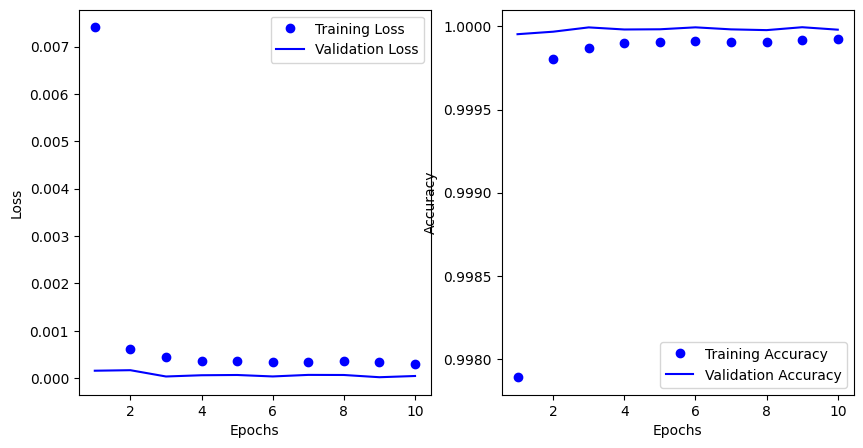

In [43]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
accuracy_values = history_dict['accuracy']
val_accuracy_values = history_dict['val_accuracy']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, loss_values, 'bo', label='Training Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, accuracy_values, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy_values, 'b', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

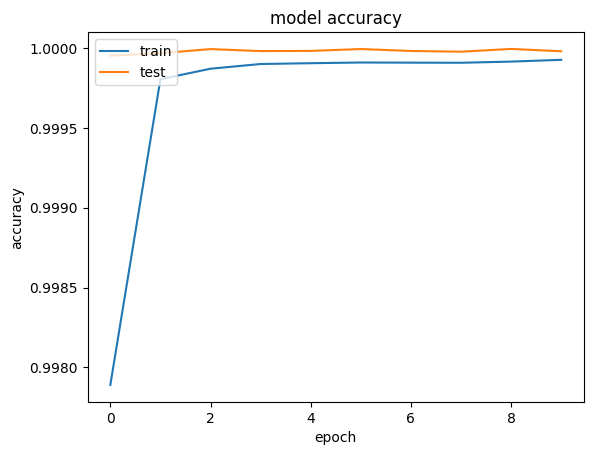

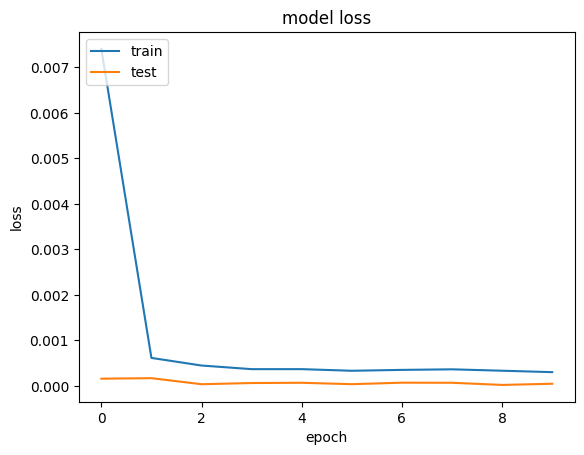

In [34]:
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [92]:
model.save("lstm model without kerenel.h5")

In [23]:
from tensorflow.keras.regularizers import l1

from keras.layers import LSTM, Dense
from keras.models import Sequential

In [37]:
model1 = Sequential()
model1.add(Dense(488, activation='relu', input_shape=(X_train_scaled.shape[1],)))
model1.add(Dropout(0.0))
model1.add(Dense(200, activation='relu'))
model1.add(Dropout(0.0))
model1.add(Dense(10, activation='softmax'))

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
               loss='sparse_categorical_crossentropy',  # Update the loss function based on your problem
               metrics=['accuracy'])

In [38]:
X_train_scaled.shape

(12376874, 5)

In [39]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 488)               2928      
                                                                 
 dropout_4 (Dropout)         (None, 488)               0         
                                                                 
 dense_6 (Dense)             (None, 200)               97800     
                                                                 
 dropout_5 (Dropout)         (None, 200)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                2010      
                                                                 
Total params: 102738 (401.32 KB)
Trainable params: 102738 (401.32 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
print("Results:")
print("---------------------")
scores_train = model1.evaluate(X_train_scaled, y_train)
print("Training Accuracy: %.2f%%\n" % (scores_train[1] * 100))
scores_test = model1.evaluate(X_test_scaled, y_test)
print("Testing Accuracy: %.2f%%\n" % (scores_test[1] * 100))

Results:
---------------------
386778/386778 [==============================] - 754s 2ms/step - loss: 0.1740 - accuracy: 0.9321
Training Accuracy: 93.21%

128926/128926 [==============================] - 253s 2ms/step - loss: 0.1742 - accuracy: 0.9320
Testing Accuracy: 93.20%



In [49]:
loss, accuracy = model1.evaluate(X_test_scaled, y_test)
print("Testing Loss:", loss)
print("Testing Accuracy:", accuracy)

128926/128926 [==============================] - 195s 2ms/step - loss: 0.1742 - accuracy: 0.9320
Testing Loss: 0.17416228353977203
Testing Accuracy: 0.9320005774497986


In [41]:
history1 = model1.fit(X_train_scaled, y_train, epochs = 20,batch_size=512 ,validation_data = (X_test_scaled, y_test))


Epoch 1/20
24174/24174 [==============================] - 135s 5ms/step - loss: 0.3176 - accuracy: 0.8790 - val_loss: 0.2474 - val_accuracy: 0.9049
Epoch 2/20
24174/24174 [==============================] - 132s 5ms/step - loss: 0.2317 - accuracy: 0.9114 - val_loss: 0.2202 - val_accuracy: 0.9152
Epoch 3/20
24174/24174 [==============================] - 144s 6ms/step - loss: 0.2142 - accuracy: 0.9173 - val_loss: 0.2090 - val_accuracy: 0.9192
Epoch 4/20
24174/24174 [==============================] - 140s 6ms/step - loss: 0.2053 - accuracy: 0.9206 - val_loss: 0.2023 - val_accuracy: 0.9214
Epoch 5/20
24174/24174 [==============================] - 141s 6ms/step - loss: 0.1997 - accuracy: 0.9228 - val_loss: 0.1987 - val_accuracy: 0.9232
Epoch 6/20
24174/24174 [==============================] - 147s 6ms/step - loss: 0.1957 - accuracy: 0.9243 - val_loss: 0.1925 - val_accuracy: 0.9255
Epoch 7/20
24174/24174 [==============================] - 141s 6ms/step - loss: 0.1925 - accuracy: 0.9254 - val_

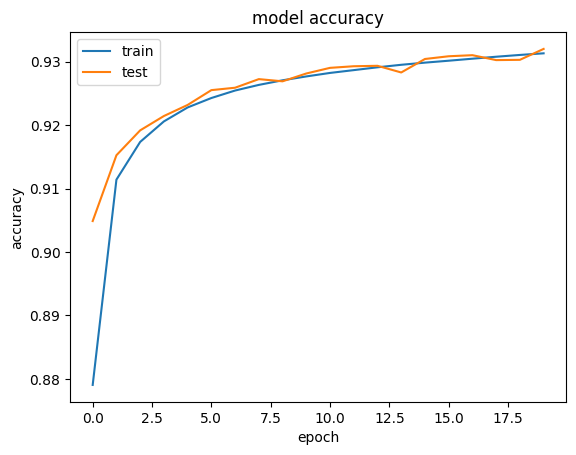

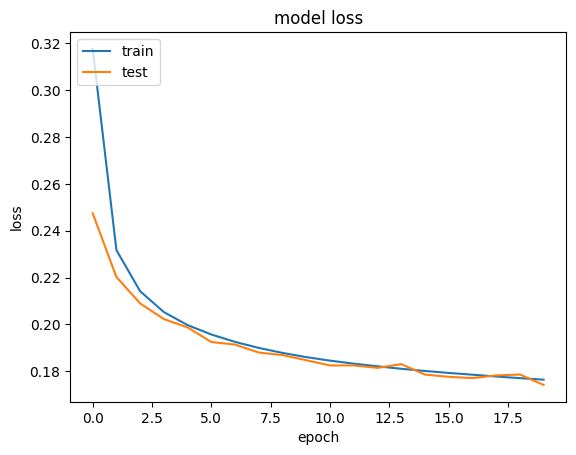

In [42]:
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [ ]:
model1.save("84precent.h5")

In [25]:
history2 = model1.fit(X_train_scaled, y_train, epochs = 15,batch_size=128 ,validation_data = (X_test_scaled, y_test))

Epoch 1/15
  590/96695 [..............................] - ETA: 4:02 - loss: 0.4263 - accuracy: 0.8366

KeyboardInterrupt: 

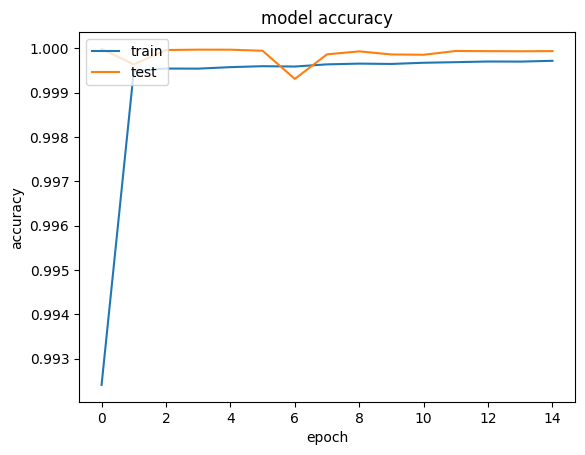

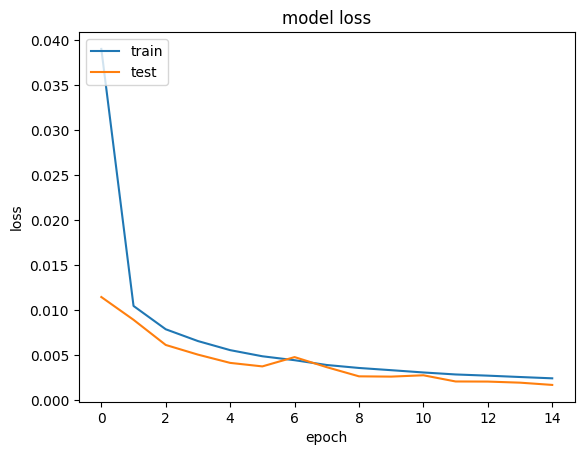

In [80]:
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [43]:
y_pred1 = model1.predict(X_test_scaled)

128926/128926 [==============================] - 181s 1ms/step


In [44]:
y_pred1

array([[9.9994385e-01, 2.5039644e-06, 3.7866253e-06, ..., 2.5981467e-12,
        1.5082822e-12, 4.2656746e-12],
       [9.9999607e-01, 8.1102104e-12, 6.1227034e-08, ..., 7.7055172e-19,
        5.2828270e-18, 5.7029507e-19],
       [1.2262845e-02, 4.9931921e-05, 1.9170407e-11, ..., 3.7794403e-14,
        1.7145058e-14, 1.1689066e-13],
       ...,
       [8.3274450e-03, 6.5958458e-03, 8.5883523e-09, ..., 1.2711354e-14,
        8.5556265e-15, 3.9440419e-14],
       [9.9691558e-01, 2.6913113e-03, 3.9316050e-04, ..., 7.7047419e-16,
        4.1644726e-17, 1.6419055e-16],
       [4.2426041e-03, 9.9574775e-01, 9.6246413e-06, ..., 2.0935178e-22,
        4.5453716e-24, 1.5623107e-24]], dtype=float32)

In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix
y_pred_classes = np.argmax(y_pred1, axis=1)

# If y_test is one-hot encoded, convert to class labels
if len(y_test.shape) > 1:
    y_test_classes = np.argmax(y_test, axis=1)
else:
    y_test_classes = y_test  # Assuming y_test is already class labels

accuracy = accuracy_score(y_test_classes, y_pred_classes)
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.9320006059687926
Confusion Matrix:
[[1880008   25649   61651   25574   42122]
 [  23016  788444    3006       1    1964]
 [  39515    2599  415905    2208    1770]
 [  10898       0    1187  239639    8427]
 [  18724    1329    3631    7269  521089]]


In [46]:
y_test_classes

5071985     0.0
4721249     0.0
4231435     4.0
2964711     1.0
3856037     4.0
           ... 
445736      0.0
11920684    2.0
9108573     4.0
9893775     0.0
2449961     1.0
Name: label, Length: 4125625, dtype: float64

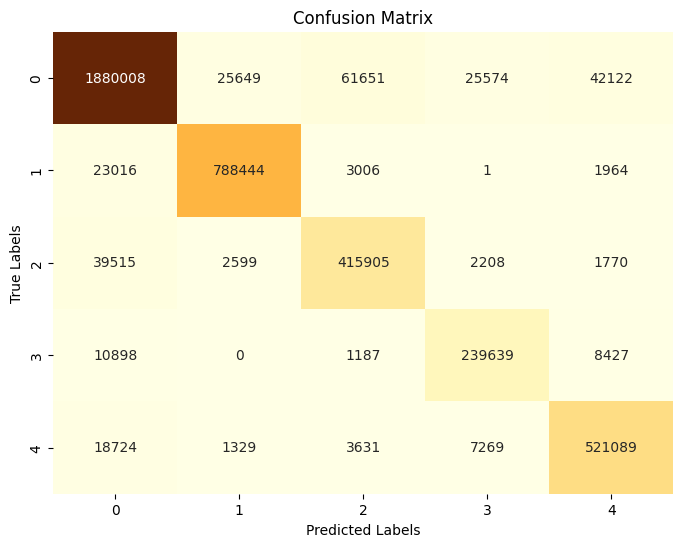

In [47]:
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrBr', cbar=False,
            )  # 'labels' should be a list of class names (if available)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [31]:
model1.save("84precent.h5")

C:\Users\pojit\AppData\Roaming\Python\Python310\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [93]:
history3 = model1.fit(X_train_scaled, y_train, epochs = 5, validation_data = (X_test_scaled, y_test))


Epoch 1/5
386778/386778 [==============================] - 1486s 4ms/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9998
Epoch 2/5
386778/386778 [==============================] - 1419s 4ms/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0019 - val_accuracy: 0.9999
Epoch 3/5
386778/386778 [==============================] - 1393s 4ms/step - loss: 0.0030 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9999
Epoch 4/5
386778/386778 [==============================] - 1416s 4ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9999
Epoch 5/5
386778/386778 [==============================] - 1418s 4ms/step - loss: 0.0027 - accuracy: 0.9995 - val_loss: 0.0017 - val_accuracy: 0.9999


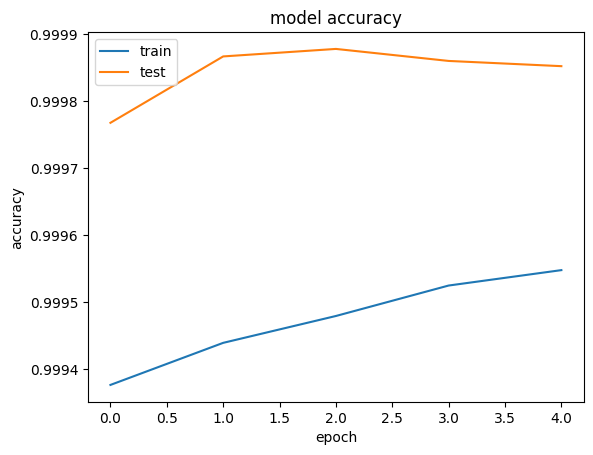

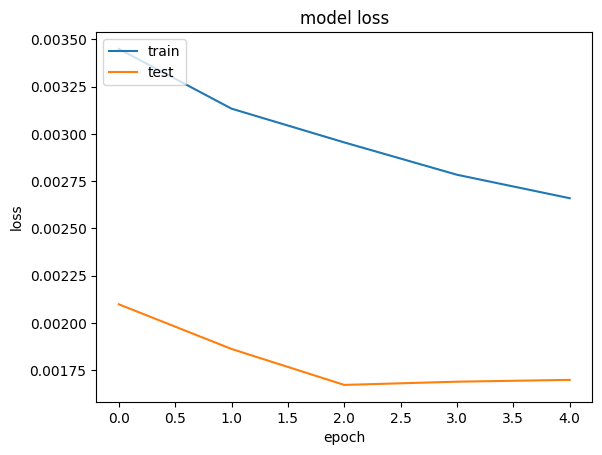

In [94]:
import matplotlib.pyplot as plt

# summarize the history for accuracy
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# summarize the history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()